In [1]:
# Copyright 2020 IITK EE604A Image Processing. All Rights Reserved.
# 
# Licensed under the MIT License. Use and/or modification of this code outside of EE604 must reference:
#
# © IITK EE604A Image Processing 
# https://github.com/ee604/ee604_assignments
#
# Author: Shashi Kant Gupta, Chiranjeev Prachand and Prof K. S. Venkatesh, Department of Electrical Engineering, IIT Kanpur

# Task 2: Image Compression: SVD

In image transforms you studied about diagonalisation. SVD decomposition works in similar way and decomposes your image $I = USV^*$, in case of I being a square matrix of size $mxm$, $S$ results into a diagonal matrix of size $mxm$ with its diagonal entries called as the singular values. Now consider writing $U = [u_1, u_2, ..., u_m]$, $V^* = [v_1; v_2; ...; v_m]$, and $S = diag(s_1, s_2, ..., s_m)$. Here $u_i$ are the columns of $U$, $v_i$ are the rows of $V^*$, and $s_i$ are the diagonal entries of $S$. Then you can re write $I$ as:

$$
I = \sum_i^m s_i*matrix\_dot(u_i, v_i)
$$

Now, consider arranging $s_i$ into a decreasing order. You will find that mostly $s_m << s_0$. So, we can use this to smartly compress the original by only using the first k singular values. 

$$
I_{compressed} = \sum_i^k s_i*matrix\_dot(u_i, v_i)
$$

Note the difference originally you need $O(n^2)$ space but now you need only $O(kn)$ space.

### Your task:
In this you will write a program, which will compress the original image using SVD decomposition at a given k value and will then compare the compressed images with the original image using **SSIM** and **MSE** metrics. You can use skimage module for these metrics, refer [this](https://scikit-image.org/docs/dev/auto_examples/transform/plot_ssim.html).

PS: You are allowed to use numpy SVD module: https://numpy.org/doc/stable/reference/generated/numpy.linalg.svd.html

In [2]:
%%bash
pip install git+https://github.com/ee604/ee604_plugins 

  Cloning https://github.com/ee604/ee604_plugins to /tmp/pip-req-build-q1t06x7u
  Created wheel for ee604-plugins: filename=ee604_plugins-0.4.2-cp36-none-any.whl size=2457 sha256=76be9906b91fe98120a9b4b3a13c062f4268184fa4cf2c05bb7ed735dbf15ac0
  Stored in directory: /tmp/pip-ephem-wheel-cache-gej6ari9/wheels/34/a8/1d/ae3b7d209ecde89b4800a47ec55a61e7503bb9548bbb975806
Successfully built ee604-plugins


  Running command git clone -q https://github.com/ee604/ee604_plugins /tmp/pip-req-build-q1t06x7u


In [3]:
# Importing required libraries

import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import skimage

from ee604_plugins import download_dataset, cv2_imshow

download_dataset(assignment_no=4, task_no=2) # download data for this assignment

Download Complete!


In [4]:
# These are some helper function which you may need. 
# Do not change or modify these.

def save_svd_image(filename, u, s, v):
    '''
    Use extension as svdim, i.e. your filname must be something like this: "data/image.svdim"
    
    Assumes USV* have their singular value arranged in decreasing order.
    Inputs:
    + u - should be a numpy array of size m x k, with its columns equals to first k columns of U
    + v - should be a numpy array of size k x m, with its rows equals to first k rows of V*
    + s - should be a numpy array of size k, with its entries equals to first k singular values
    '''
    
    np.savez_compressed(filename + ".npz", u=u, s=s, v=v)
    
def load_svd_image(filename):
    '''
    Load the svd image saved in .npz file and returns the corresponding u, s, v
    
    Returns:
    + u - should be a numpy array of size m x k, with its columns equals to first k columns of U
    + v - should be a numpy array of size k x m, with its rows equals to first k rows of V*
    + s - should be a numpy array of size k, with its entries equals to first k singular values
    '''
        
    data = np.load(filename + ".npz")
    
    u = data['u']
    v = data['v']
    s = data['s']
    
    return u, s, v

def get_file_size(filename):
    '''
    Retreive the size of the file
    '''
    if filename[-6:] == ".svdim":
        filename = filename + ".npz"
    
    b = os.path.getsize(filename)
        
    return round(b/1000, 1)

In [5]:
def svd_playground(img, k):
    '''
    Inside this function do the task as described above, i.e. use SVD to compress the given image at a given k value.
    Compare the compressed image with the original image using SSIM and MSE metrics. 
    Return ssim, mse and stored size for the image.
    
    Inputs:
    + img - grayscaled image of size N x N
          - values between [0, 255] - 'uint8'
    + k - number of k singular value to use
    
    Ouputs:
    + ssim - SSIM metric between the compressed image and original image.
    + mse - MSE metric between the compressed image and original image.
    + size - size of the the compressed image using the save_svd_image() function. Make sure you use ".svdim"
           - as extension when you save using the save_svd_image() function.
    
    Allowed external package:
    + Any relevant module in openCV, numpy, skimage.
    
    '''
    
    #############################
    # Start your code from here #
    #############################
    from skimage.metrics import structural_similarity as ssim
    from skimage.metrics import mean_squared_error
    
    U, S, V = np.linalg.svd(img, full_matrices=False)
    out_img = np.dot(U[:,:k], np.dot(np.diag(S[:k]), V[:k,:]))
    out_img = np.clip(out_img, 0, 255)
    
    U2 = U[:,:k]
    S2=  S[:k] 
    V2 = V[:k,:]

    save_svd_image('svd.svdim', U2, S2, V2)
    size = get_file_size('svd.svdim')

    mse = mean_squared_error(img, out_img)
    ssim = ssim(img, out_img, 
                data_range=out_img.max() - out_img.min())

    #############################
    # End your code here ########
    #############################
    
    return ssim, mse, size

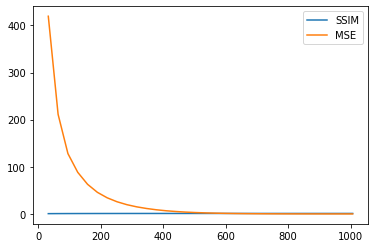

In [6]:
# Do not change codes inside this cell
# Add your observations in next cell

img = cv2.imread("data/lena_gray.jpg", 0)

ssim_a = []
mse_a = []
size_a = []
for k in range(8, 257, 8):
    ssim, mse, size = svd_playground(np.copy(img), k)
    
    ssim_a.append(ssim)
    mse_a.append(mse)
    size_a.append(size)
    
plt.plot(size_a, ssim_a, label="SSIM")
plt.plot(size_a, mse_a, label="MSE")
plt.legend()
plt.show()

In [7]:
# Add your observations; compare the effect of compression on SSIM and MSE.

your_observation = """
As the k value is increased the losses reduce and size increases as compression strength is lowered
"""

print(your_observation)


As the k value is increased the losses reduce and size increases as compression strength is lowered

